In [73]:
from matplotlib import pyplot as plt
import networkx as nx
import random
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import truncnorm as dist

In [134]:
#Adapted from C. Scheffler: https://gist.github.com/cscheffler/f8f8416513356e184e9568fa69c90889

class SocialDynamicsSimulation:
    '''
    Simulate social dynamics by strengthening opinions and connection weights
    based on random interactions between nodes.
    '''

    def __init__(self, network_size=50, alpha=0.03, beta=0.3, gamma=4, eta=0.03,\
                       alpha_std=0.0001, beta_std=0.0001, gamma_std=0.0001, eta_std=0.0001):
        '''
        Inputs:

            network_size (int) The number of nodes in the random Barabasi-Albert
              small-world network. Default: 50.

            alpha (float) The average rate at which nodes adjust their opinions to
              match neighboring nodes' opinions during interactions.
              Default: 0.03.

            beta (float) The average rate at which edge weights are changed in
              response to differing opinions. Default: 0.3.

            gamma (float) The average pickiness of nodes. Nodes with opinions differing
              by more than 1/gamma will result in an edge weight decreasing.
              Default: 4.
              
            eta (float) The average rate in which the global opinion affect the change in 
              the opinion of the node at every step. Default: 0.03.
              
            alpha_std (float) The standard deviation of the alpha parameter in 
              the truncated normal distribution. Default 0.0001.
              
            beta_std (float) The standard deviation of the beta parameter in 
              the truncated normal distribution. Default 0.0001.
              
            gamma_std (float) The standard deviation of the gamma parameter in 
              the truncated normal distribution. Default 0.0001.
              
            eta_std (float) The standard deviation of the etaa parameter in 
              the truncated normal distribution. Default 0.0001.
        '''
        self.network_size = network_size
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.eta = eta
        self.alpha_std = alpha_std
        self.beta_std = beta_std
        self.gamma_std = gamma_std 
        self.eta_std = eta_std
        self.average_opinion = []

    def initialize(self):
        '''
        Initialize the simulation with a random graph, with random 0 or 1
        opinions assigned to all nodes and initial edge weights of 0.5.
        '''
        self.graph = nx.barabasi_albert_graph(self.network_size, 3)
        for edge in self.graph.edges:
            self.graph.edges[edge]['weight'] = 0.5
            self.graph.edges[edge]['beta'] = dist.rvs(a=0, b=1, loc=self.beta, scale=self.beta_std, size=1)[0]
            self.graph.edges[edge]['gamma'] = dist.rvs(a=0, b=1 + self.graph.edges[edge]['beta']**(-1),\
                                                       loc=self.gamma, scale=self.gamma_std, size=1)[0]
        for node in self.graph.nodes:
            self.graph.nodes[node]['opinion'] = random.randint(0, 1)
            self.graph.nodes[node]['alpha'] = dist.rvs(a=0, b=1, loc=self.alpha, scale=self.alpha_std, size=1)[0]
            self.graph.nodes[node]['eta'] = dist.rvs(a=0, b=1, loc=self.eta, scale=self.eta_std, size=1)[0]
        self.layout = nx.spring_layout(self.graph)  # Initial visual layout
        self.step = 0

    def observe(self):
        '''
        Draw the state of the network.
        '''
        self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=5)
        plt.clf()
        nx.draw(
            self.graph, pos=self.layout, with_labels=True,
            node_color=[self.graph.nodes[i]['opinion'] for i in self.graph.nodes],
            edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
            edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
            alpha=0.7, vmin=0, vmax=1)
        plt.title('Step: ' + str(self.step))

    def update(self):
        '''
        Perform an update step
        '''
        if random.uniform(0, 1) < 0.01:
            # Create a new edge with weight proportional to the difference of 
            # opinion between two unconnected nodes
            nodes = list(self.graph.nodes)
            while True:
                new_edge = random.sample(nodes, 2)
                if new_edge not in self.graph.edges:
                    break
            if self.graph.nodes[new_edge[0]]['opinion'] == 0 or self.graph.nodes[new_edge[1]]['opinion'] == 0:
                new_weight = 0
            else: 
                new_weight = self.graph.nodes[new_edge[0]]['opinion']/self.graph.nodes[new_edge[1]]['opinion']
            if new_weight > 1: 
                new_weight = 1/new_weight
            self.graph.add_edge(new_edge[0], new_edge[1], weight=new_weight)
            self.graph.edges[new_edge]['weight'] = 0.5
            self.graph.edges[new_edge]['beta'] = dist.rvs(a=0, b=1, loc=self.beta, scale=self.beta_std, size=1)[0]
            self.graph.edges[new_edge]['gamma'] = dist.rvs(a=0, b=1 + self.graph.edges[new_edge]['beta']**(-1),\
                                                       loc=self.gamma, scale=self.gamma_std, size=1)[0]
        else:
            # Select a random edge and update node opinions and edge weight
            edge = random.choice(list(self.graph.edges))
            weight = self.graph.edges[edge]['weight']
            opinions = [self.graph.nodes[n]['opinion'] for n in edge]
            average_opinion = np.mean([self.graph.nodes[i]['opinion'] for i in self.graph.nodes])
            for i in [0, 1]:
                self.graph.nodes[edge[i]]['opinion'] = (
                    opinions[i] + self.graph.nodes[edge[i]]['alpha'] * weight * (opinions[1-i] - opinions[i])
                    + self.graph.nodes[edge[i]]['eta']*(average_opinion - opinions[i]))
            self.graph.edges[edge]['weight'] = (weight +\
                                                self.graph.edges[edge]['beta'] * weight * (1-weight) *\
                                                (1 - self.graph.edges[edge]['gamma'] * abs(opinions[0] - opinions[1])))
            # Remove very weak connections
            if self.graph.edges[edge]['weight'] < 0.05:
                self.graph.remove_edge(*edge)
        #Log the time step
        self.step += 1
        #Log the average opionon
        average_opinion = np.mean([self.graph.nodes[i]['opinion'] for i in self.graph.nodes])
        self.average_opinion.append(average_opinion)
        
    def plot_average(self): 
        plt.figure(figsize=(12,8))
        plt.plot(range(self.step), self.average_opinion)
        plt.title('Average Opinion: alpha {}, beta {}, gamma {}, eta {}, std {}'.format(self.alpha, self.beta,\
                                                                                        self.gamma, self.eta,\
                                                                                        self.alpha_std))
        plt.ylabel('Opinion')
        plt.xlabel('Time step')
        plt.show()

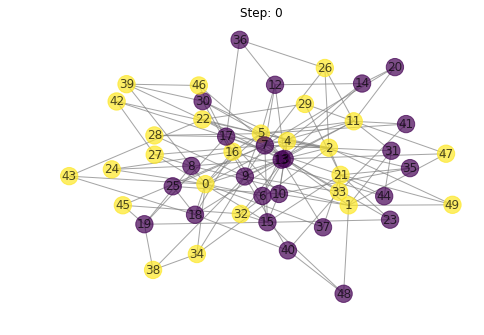

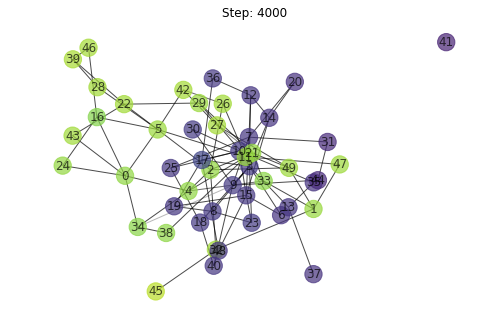

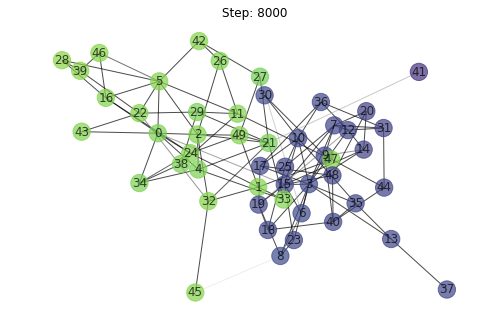

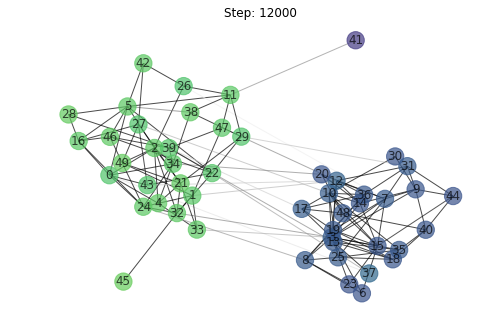

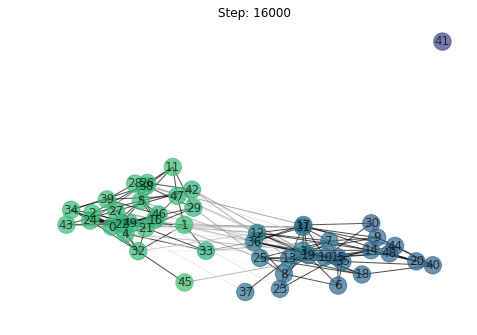

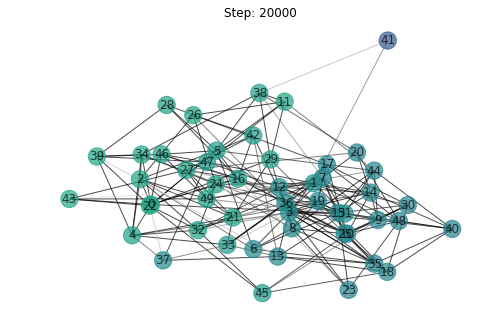

In [175]:
sim = SocialDynamicsSimulation(alpha=0.03, beta=0.3, gamma=3.5, eta=0,\
                               alpha_std=0.01, beta_std=0.01, gamma_std=0.01, eta_std=0.001)
sim.initialize()
plt.figure()
sim.observe()
for i in range(5):
    for i in range(4000):
        sim.update()
    plt.figure()
    sim.observe()

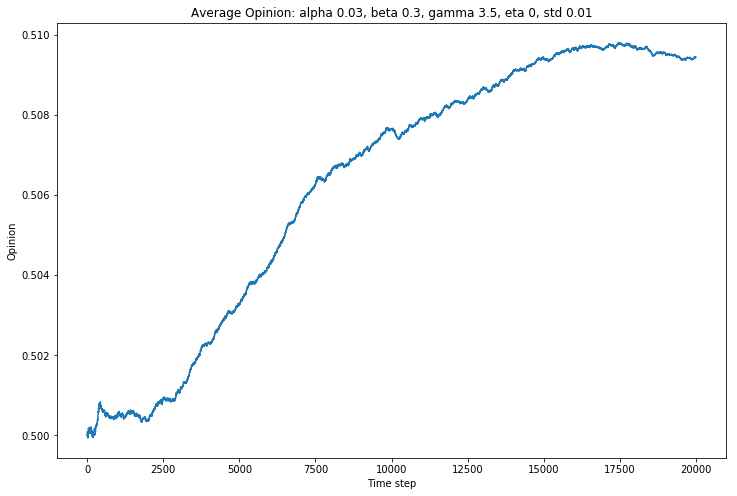

In [176]:
sim.plot_average()

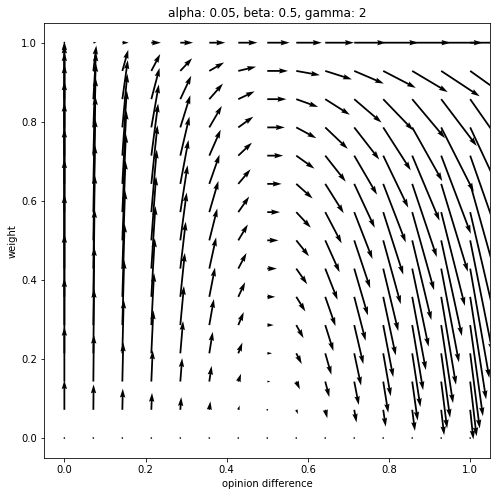

In [66]:
#2D Vector field plots
alpha = 0.05
beta = 0.5
gamma = 2

# Create grid coordinates
opinion_difference = np.linspace(0, 1, 15)
edge_weight = np.linspace(0, 1, 15)
op_dif_grid, weight_grid = np.meshgrid(opinion_difference, edge_weight)

# Compute vector field
vector_x = alpha*weight_grid*op_dif_grid
vector_y = beta*weight_grid*(1-weight_grid)*(1-gamma*op_dif_grid)

# Plot vector field
plt.figure(figsize=(8, 8))
plt.quiver(op_dif_grid, weight_grid, vector_x, vector_y, scale=0.5)
plt.title('alpha: {}, beta: {}, gamma: {}'.format(alpha, beta, gamma))
plt.xlabel('opinion difference')
plt.ylabel('weight')
plt.show()

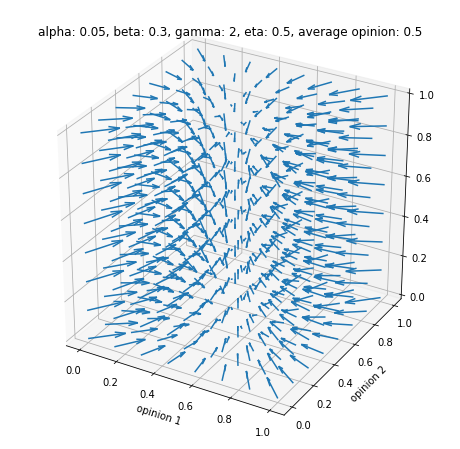

In [68]:
#3D vector field
# %matplotlib notebook #--toggle to move the 3D graph around
alpha = 0.05 
beta = 0.3
gamma = 2
eta = 0.5
average_op = 0.5

# Create grid coordinates
opinion_1 = np.linspace(0, 1, 8)
opinion_2 = np.linspace(0, 1, 8)
edge_weight = np.linspace(0, 1, 8)

x, y, z = np.meshgrid(opinion_1, opinion_2, edge_weight)

# Compute vector field
vector_x = alpha*z*(x-y) + eta*(average_op - x)
vector_y = alpha*z*(y-x) + eta*(average_op - y)
vector_z = beta*z*(1-z)*(1-gamma*np.abs(x-y))

# Plot vector field
plt.figure(figsize=(8, 8))
plt.gca(projection='3d')
plt.quiver(x, y, z, vector_x, vector_y, vector_z, length=0.5)
plt.title('alpha: {}, beta: {}, gamma: {}, eta: {}, average opinion: {}'.format(alpha, beta, gamma, eta, average_op))
plt.xlabel('opinion 1')
plt.ylabel('opinion 2')
plt.show()
